### Objectives: 

* A combined-cycle power plant comprises gas turbines, steam turbines, and heat recovery steam generators. 
  In this type of plant, the electricity is generated by gas and steam turbines combined in one cycle. 
  Then, it is transferred from one turbine to another. 
  
* We have to model the energy generated as a function of exhaust vacuum and ambient variables 
  and use that model to improve the plant's performance. 


# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("Copy of energy_production (1).csv")
data.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
0,9.59,38.56,1017.01,60.10,481.30
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58


# Exploratory Data Analysis

In [3]:
data.shape

(9568, 5)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        9568 non-null   float64
 1   exhaust_vacuum     9568 non-null   float64
 2   amb_pressure       9568 non-null   float64
 3   r_humidity         9568 non-null   float64
 4   energy_production  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [5]:
data.isnull().sum()

temperature          0
exhaust_vacuum       0
amb_pressure         0
r_humidity           0
energy_production    0
dtype: int64

In [6]:
data.duplicated().sum()

41

In [7]:
data_cleaned = data.drop_duplicates()
data_cleaned.to_csv('cleaned_file_no_duplicates.csv', index=False)
print(data_cleaned.head())

   temperature  exhaust_vacuum  amb_pressure  r_humidity  energy_production
0         9.59           38.56       1017.01       60.10             481.30
1        12.04           42.34       1019.72       94.67             465.36
2        13.87           45.08       1024.42       81.69             465.48
3        13.72           54.30       1017.89       79.08             467.05
4        15.14           49.64       1023.78       75.00             463.58


In [8]:
data.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


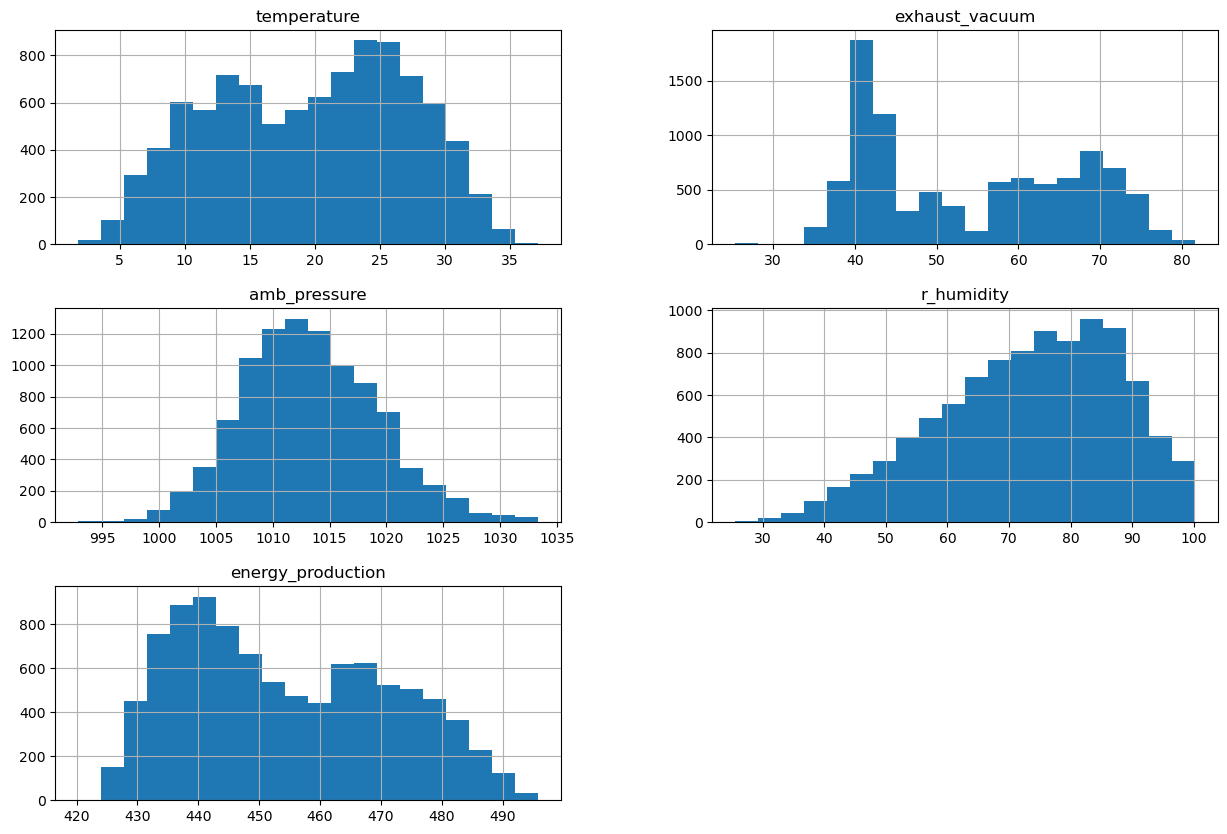

In [9]:
data.hist(bins=20, figsize=(15, 10))
plt.show()

### Correlation Analysis

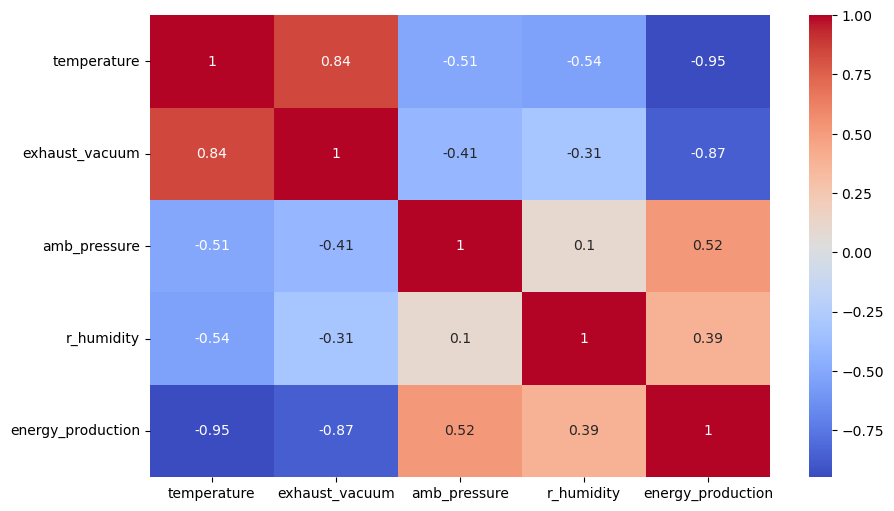

In [10]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

### Insights

* There's a strong negative correlation of −0.95 between temperature and energy production. This suggests that as temperature increases, energy production decreases significantly. Temperature is a critical factor affecting energy production efficiency.


* Exhaust vacuum also has a strong negative correlation of −0.87 with energy production. Higher exhaust vacuum values are associated with lower energy production. This indicates that managing exhaust conditions is crucial for maximizing energy output.


* There's a moderate positive correlation of 0.52 between ambient pressure and energy production. Higher ambient pressure tends to enhance energy production, though the effect is less pronounced compared to temperature and exhaust vacuum.


* Relative humidity has a weak positive correlation of 0.39 with energy production. This indicates that while humidity does have some impact, it's less significant compared to other factors like temperature and exhaust vacuum.


* In summary, the heatmap reveals that temperature and exhaust vacuum are the most critical factors negatively affecting energy production, while ambient pressure has a positive impact.

### Pairwise Relationships

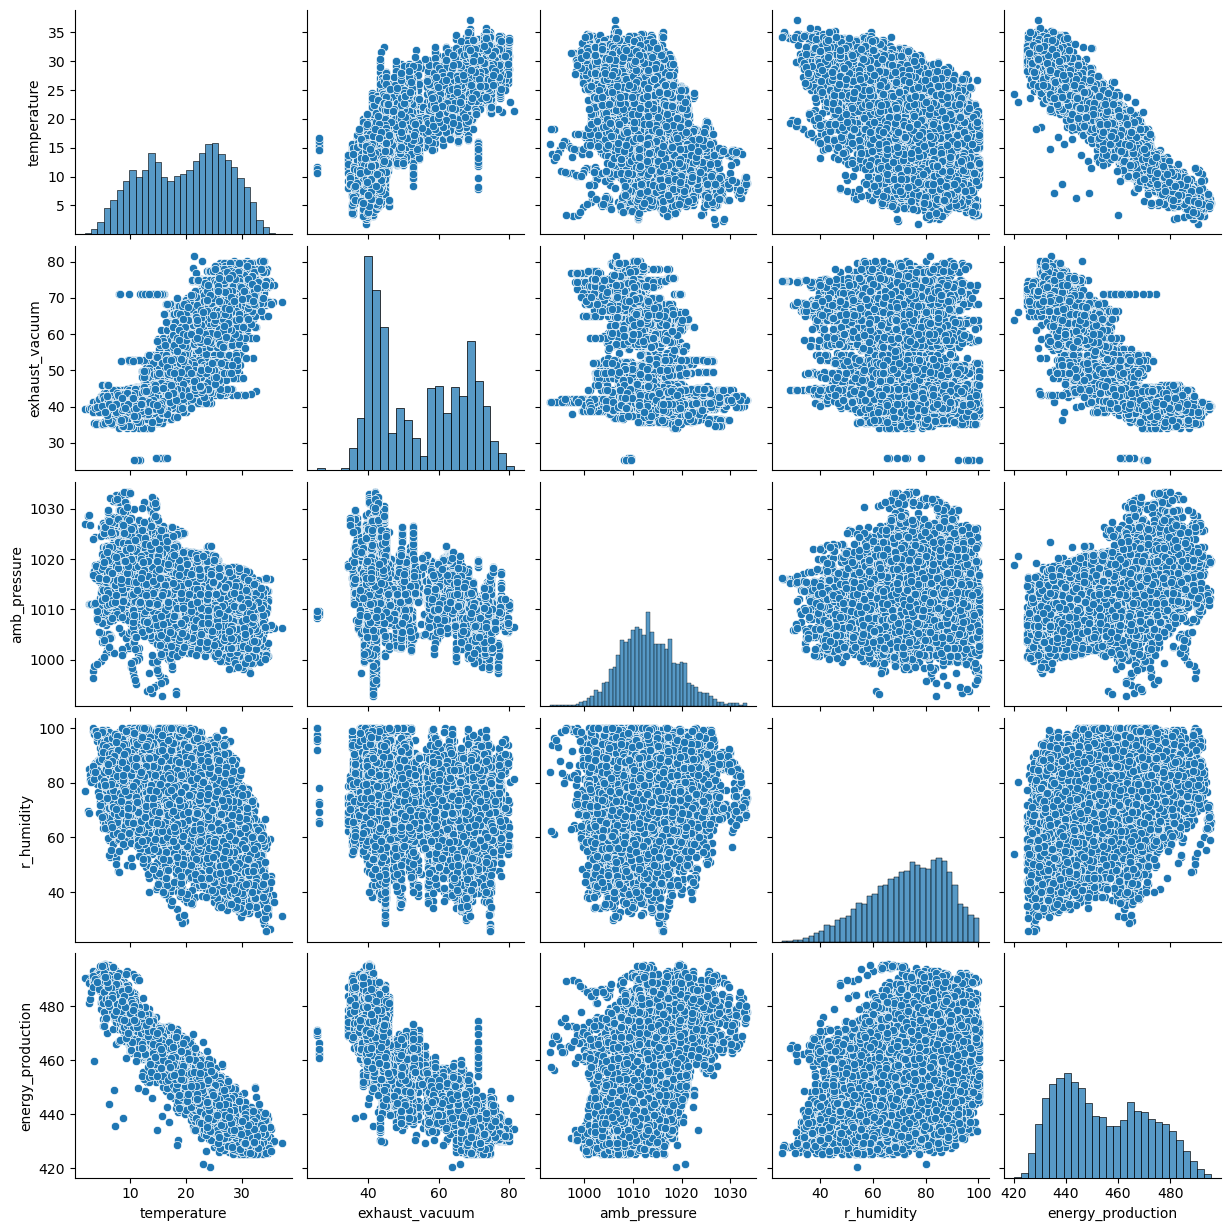

In [11]:
sns.pairplot(data)
plt.show()

### Insights

* There is a noticeable negative relationship between temperature and energy production. As temperature increases, energy production tends to decrease. This aligns with the strong negative correlation observed in the heatmap.

* A similar negative relationship exists between exhaust vacuum and energy production. Higher exhaust vacuum values correspond to lower energy production, further confirming the correlation from the heatmap.


* The scatterplot between ambient pressure and energy production shows a positive relationship, though it is less pronounced than the negative relationships observed with temperature and exhaust vacuum.


* The relationship between relative humidity and energy production appears more scattered, indicating a weak correlation. This suggests that relative humidity has less of an impact on energy production compared to the other variables.


* The scatterplot between temperature and exhaust vacuum shows a positive relationship. This suggests that as temperature increases, exhaust vacuum tends to increase as well, which could be due to their interrelated physical processes in the power plant.


* There is a negative relationship between temperature and ambient pressure. As temperature increases, ambient pressure decreases, likely due to the thermodynamic properties of air.




* Overall, the pairplot reinforces the strong influence of temperature and exhaust vacuum on energy production, while also highlighting the complex interactions between other variables like ambient pressure and relative humidity.


### Boxplots and Outlier Detection

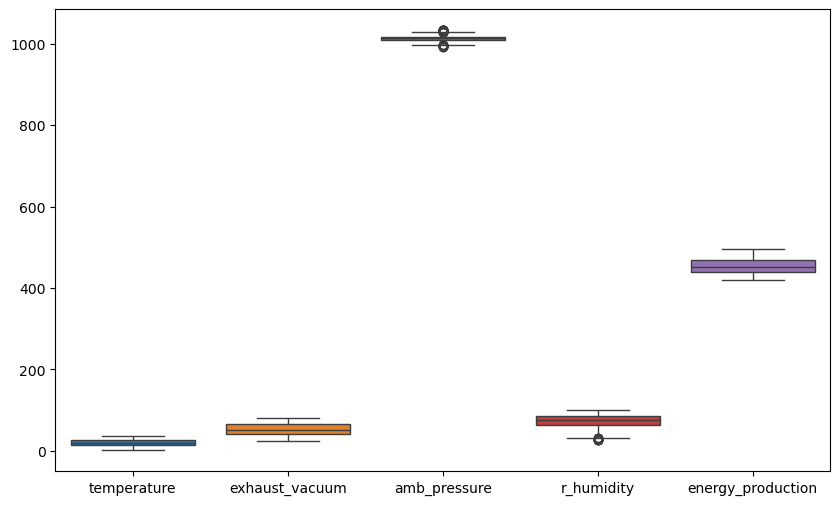

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
plt.show()


### Target Variable Analysis

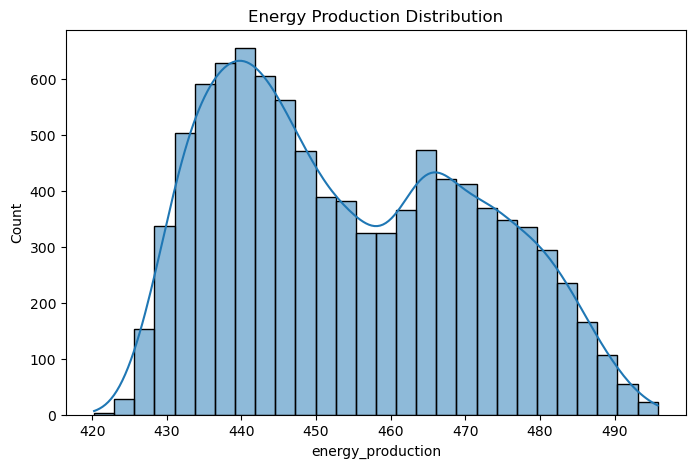

In [13]:
# Distribution plot for the target variable
plt.figure(figsize=(8, 5))
sns.histplot(data['energy_production'], kde=True)
plt.title('Energy Production Distribution')
plt.show()


###  Feature Relationships

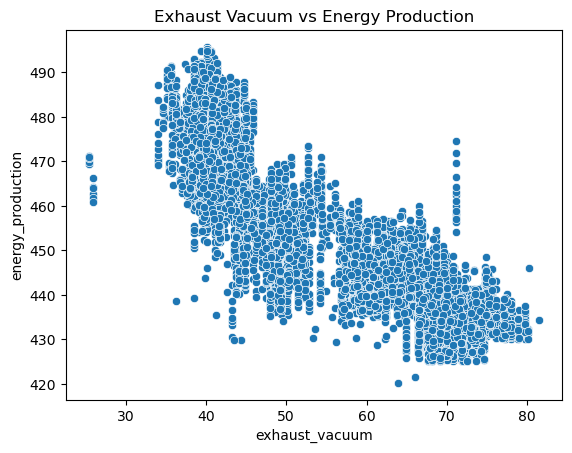

In [14]:
sns.scatterplot(x='exhaust_vacuum', y='energy_production', data=data)
plt.title('Exhaust Vacuum vs Energy Production')
plt.show()

###  Using the IQR Method to Detect Outliers

In [15]:
def detect_outliers(data_column):
    Q1 = np.percentile(data_column, 25)  
    Q3 = np.percentile(data_column, 75)  
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
     # Detect outliers
    outliers = data_column[(data_column < lower_bound) | (data_column > upper_bound)]
    return outliers

In [16]:

# Apply the function to each numerical column and print outliers
for column in data.columns:
    outliers = detect_outliers(data[column])
    print(f"Outliers in {column}:")
    print(outliers)
    print("---------------------------------------------------")

Outliers in temperature:
Series([], Name: temperature, dtype: float64)
---------------------------------------------------
Outliers in exhaust_vacuum:
Series([], Name: exhaust_vacuum, dtype: float64)
---------------------------------------------------
Outliers in amb_pressure:
38      1033.09
175     1029.90
315     1031.34
319     1030.42
385     1031.96
         ...   
9093    1030.38
9125    1031.96
9331    1029.65
9368    1031.14
9501    1030.10
Name: amb_pressure, Length: 88, dtype: float64
---------------------------------------------------
Outliers in r_humidity:
30      28.16
233     26.67
400     26.30
1154    25.89
1254    29.43
1814    30.59
5610    30.99
5674    29.86
6048    30.34
6214    28.81
7287    30.83
7936    25.56
Name: r_humidity, dtype: float64
---------------------------------------------------
Outliers in energy_production:
Series([], Name: energy_production, dtype: float64)
---------------------------------------------------


### Visualizing Outliers with Boxplots

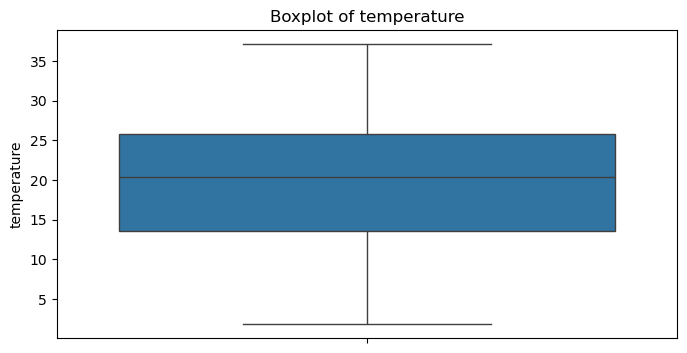

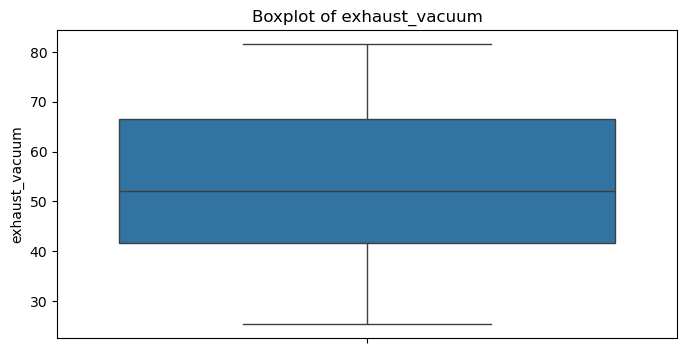

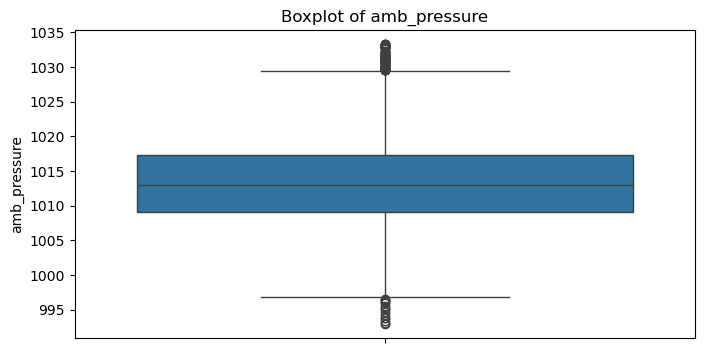

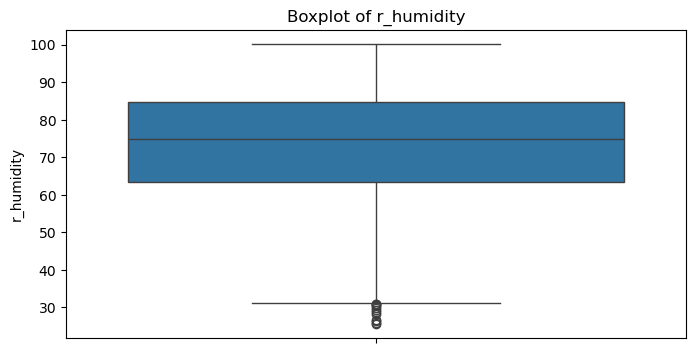

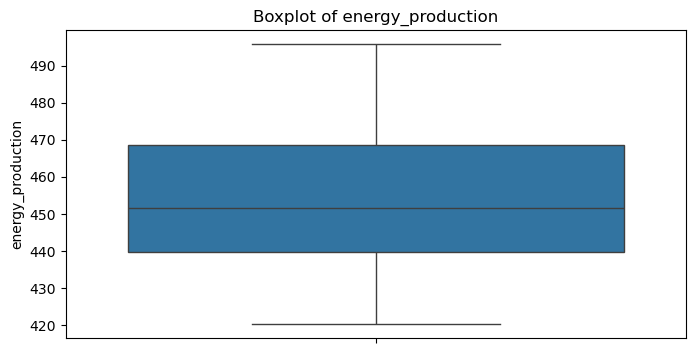

In [17]:
for column in data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

### Handling Outliers

In [18]:

# Function to calculate the lower and upper bounds for outliers
def calculate_bounds(data_column):
    Q1 = np.percentile(data_column, 25)
    Q3 = np.percentile(data_column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Remove outliers from each column
for column in data.columns:
    lower_bound, upper_bound = calculate_bounds(data[column])
    # Filter the data to remove outliers
    data_cleaned = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    print(f"Outliers removed from {column}")
    print(f"Cleaned data:\n{data_cleaned.head()}")


Outliers removed from temperature
Cleaned data:
   temperature  exhaust_vacuum  amb_pressure  r_humidity  energy_production
0         9.59           38.56       1017.01       60.10             481.30
1        12.04           42.34       1019.72       94.67             465.36
2        13.87           45.08       1024.42       81.69             465.48
3        13.72           54.30       1017.89       79.08             467.05
4        15.14           49.64       1023.78       75.00             463.58
Outliers removed from exhaust_vacuum
Cleaned data:
   temperature  exhaust_vacuum  amb_pressure  r_humidity  energy_production
0         9.59           38.56       1017.01       60.10             481.30
1        12.04           42.34       1019.72       94.67             465.36
2        13.87           45.08       1024.42       81.69             465.48
3        13.72           54.30       1017.89       79.08             467.05
4        15.14           49.64       1023.78       75.00         

### Data Normalization or Standardization

In [19]:
scaler = StandardScaler()

# Apply scaling to all the features
features = ['temperature', 'exhaust_vacuum', 'amb_pressure', 'r_humidity']
data_scaled = data_cleaned.copy()
data_scaled[features] = scaler.fit_transform(data_cleaned[features])

print(data_scaled.head())  

   temperature  exhaust_vacuum  amb_pressure  r_humidity  energy_production
0    -1.350123       -1.239122      0.631631   -0.904755             481.30
1    -1.021356       -0.941653      1.087977    1.463133             465.36
2    -0.775787       -0.726028      1.879426    0.574062             465.48
3    -0.795916       -0.000457      0.779817    0.395289             467.05
4    -0.605365       -0.367177      1.771654    0.115827             463.58


###  Variance Inflation Factor (VIF)

In [20]:
# Calculate VIF for each feature
X = data_scaled[['exhaust_vacuum', 'temperature', 'amb_pressure', 'r_humidity']]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          Feature       VIF
0  exhaust_vacuum  3.943003
1     temperature  5.977602
2    amb_pressure  1.452639
3      r_humidity  1.705290


* exhaust_vacuum (VIF = 3.94): Acceptable level of multicollinearity.
* temperature (VIF = 5.98): This score is approaching the threshold where multicollinearity could be problematic. A VIF       close to 6 suggests some level of multicollinearity, but it is not extreme.
* amb_pressure (VIF = 1.45) and r_humidity (VIF = 1.71): Both are well below the threshold, indicating low                   multicollinearity.

In [21]:
# Drop the temperature column due to moderate multicollinearity
data_cleaned = data_scaled.drop(columns=['temperature'])

# Model Building

In [22]:
X = data_cleaned[['exhaust_vacuum', 'amb_pressure', 'r_humidity']]
y = data_cleaned['energy_production']

## Linear Regression Model

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
# Predict and evaluate

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 58.56678253485467
R²: 0.8069597365227168


### Interpretation

* R² = 0.81: This means that the model explains approximately 81% of the variance in energy production, which is generally considered a good fit.
* MSE = 58.57: This reflects the average squared difference between the predicted and actual energy production values. While it's hard to interpret MSE without knowing the scale of the target variable, this value can still be compared to future models.

### Residual Analysis:

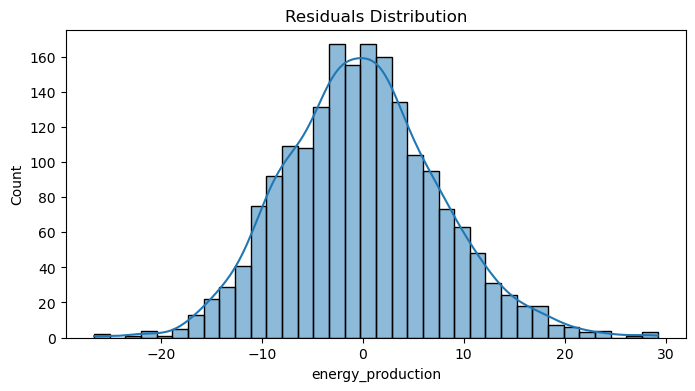

In [25]:
# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

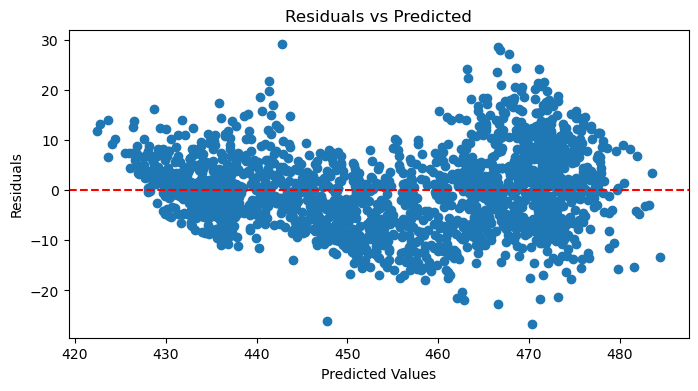

In [26]:
# Scatter plot of residuals
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

### Cross-validation:

In [27]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {scores}")
print(f"Mean R²: {scores.mean()}")

Cross-validated R² scores: [0.80383753 0.79936085 0.80577168 0.80261199 0.8022267 ]
Mean R²: 0.8027617501531136


### Interpretation

* Consistent R² scores: The small variance between the cross-validated R² scores shows that your model is not overfitting or underfitting, and its predictions are reliable across different data splits.
* Mean R² of 0.803: The model explains around 80.3% of the variance in energy production, which is a solid performance.

## Random Forest Regressor

In [28]:
# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R²:", r2_rf)

Random Forest MSE: 18.169165386936992
Random Forest R²: 0.9401131439759506


### Interpretation:


* R² = 0.94: This means the Random Forest model explains 94% of the variance in energy production, which is a substantial    improvement over the 81% from the Linear Regression.
* MSE = 18.17: The lower MSE indicates that the Random Forest model provides more accurate predictions with smaller errors compared to Linear Regression.

### Cross-validation

In [29]:
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')
print(f"Cross-validated R² scores for Random Forest: {rf_cv_scores}")
print(f"Mean R² for Random Forest: {rf_cv_scores.mean()}")

Cross-validated R² scores for Random Forest: [0.93730398 0.92708665 0.93616531 0.92317923 0.93712865]
Mean R² for Random Forest: 0.9321727665086799


* Cross-validated R² scores: The values range from 0.923 to 0.937, which indicates strong, consistent performance across different subsets of the data.
* Mean R² = 0.932: This is very close to the original R² score of 0.94 from the test set, showing that the model generalizes well.

# Hyperparameter Tuning

### Feature Importance Analysis:

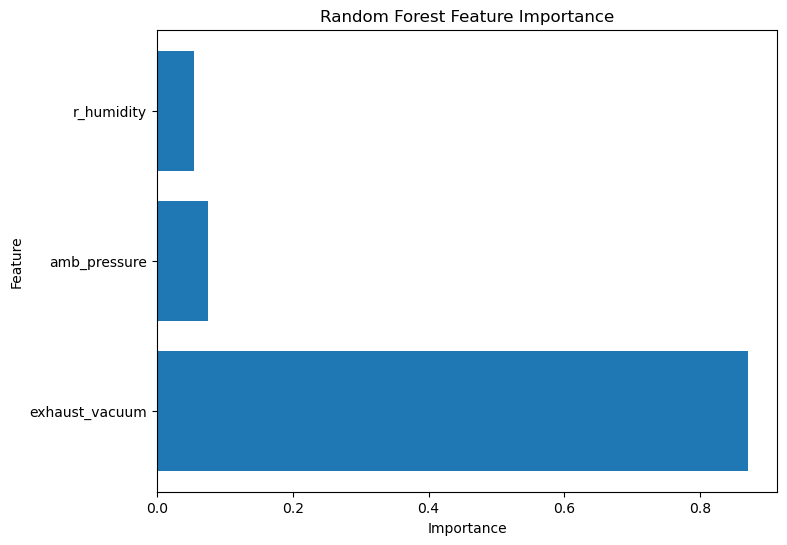

In [30]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.show()


* Exhaust Vacuum: This feature has the highest importance, contributing over 80% to the model’s predictions.
* Ambient Pressure: This feature has a moderate impact, but far less than exhaust vacuum.
* Relative Humidity: This is the least important among the three features.

### Interpretation

* The dominance of the exhaust vacuum feature suggests that it has a very strong relationship with energy production.
* The relatively lower importance of ambient pressure and relative humidity suggests that they have less influence on energy production, though they still contribute.

### Residual Analysis 

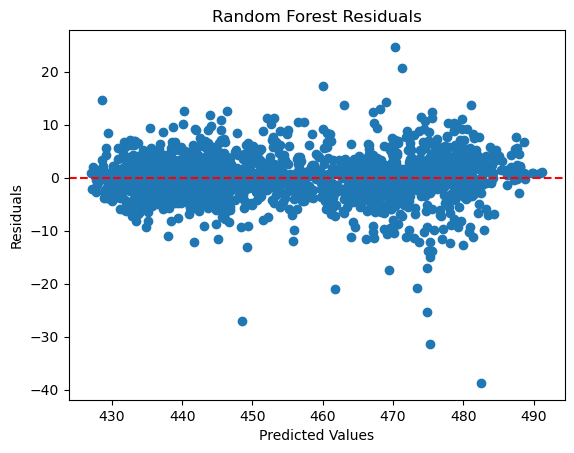

In [31]:

# Calculate residuals
residuals_rf = y_test - y_pred_rf

# Scatter plot of residuals
plt.scatter(y_pred_rf, residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Random Forest Residuals')
plt.show()

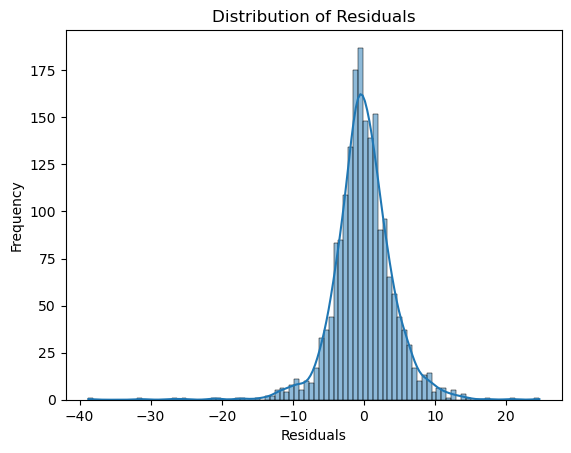

In [32]:
# Plot the distribution of residuals
sns.histplot(residuals_rf, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

### Insights

* The residuals are fairly symmetrically distributed around the horizontal line at zero, which is a positive sign.
* This suggests that the model does not exhibit significant bias; it’s not consistently overpredicting or underpredicting     the target variable (energy production).
* The residuals appear to be randomly scattered without any clear patterns. This is generally a good indicator that the       model is capturing the relationships in the data well
* Good performance: The model appears to be well-fitted with no strong signs of bias or variance issues.